This notebook helps to prepare the dataset consumed by the E2C model. The data source for this notebook comes from the output of simulation software. In this case, we use AD-GPRS from Stanford ERE department.

## Instructions for the datasets:

### File name codes:
`_norm_bhps`: dataset for normalized BHPs  
`_train`: dataset for pressure (normalized) and saturation  


    

In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [2]:
data_dir = '../data/'
case_name = '9w_ms_bhp_rate'
state_file = case_name + '_train_n_400_full'
ctrl_file = case_name + '_norm_bhps_n_400'
case_suffix = '_fix_wl_rel_8'
train_suffix = '_with_p'

state_data = state_file + case_suffix + '.mat'
ctrl_data = ctrl_file + case_suffix + '.mat'

In [3]:
hf_r = h5py.File(data_dir + state_data, 'r')
sat = np.array(hf_r.get('sat'))
pres = np.array(hf_r.get('pres'))
hf_r.close()

In [4]:
print(sat.shape)
sat = sat.T.reshape((400, 201, 3600))
pres = pres.T.reshape(400,201,3600)
print("sat shape:{}".format(sat.shape))
print("pres shape:{}".format(pres.shape))

(3600, 80400)
sat shape:(400, 201, 3600)
pres shape:(400, 201, 3600)


In [5]:
print(np.min(sat))
print(np.max(sat))

0.12278932179024149
0.6364830969098375


In [6]:
# dt = 10 # timestep, not days
days_per_step = 10

case number: 1
case number: 101
case number: 201
case number: 301


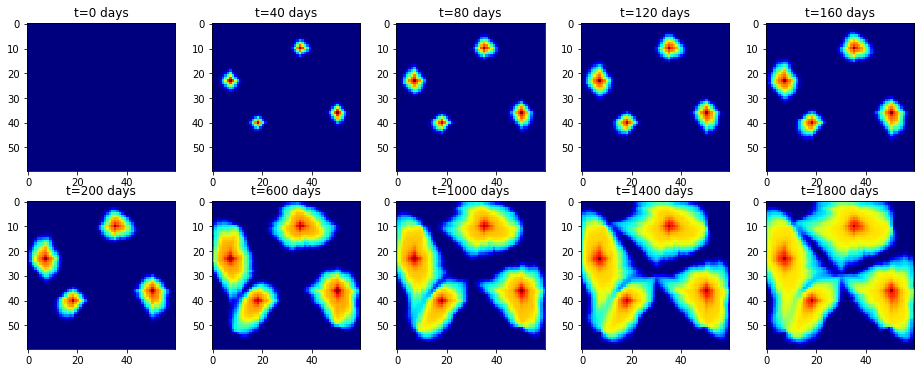

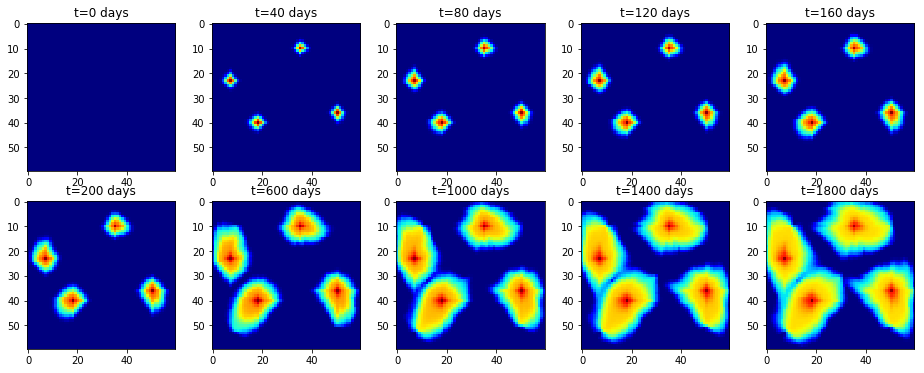

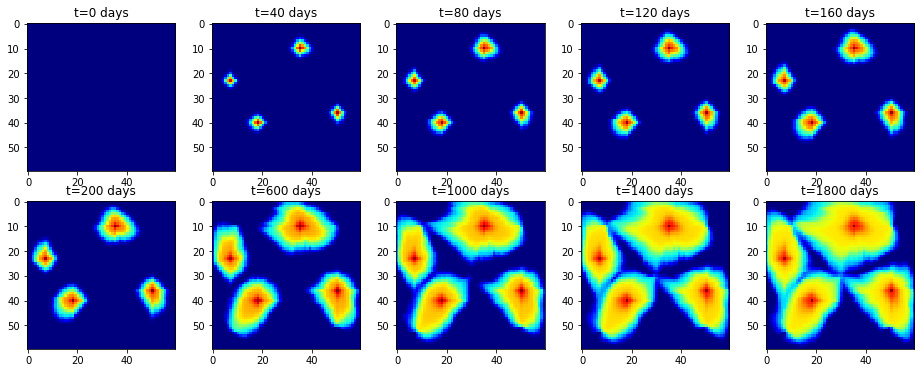

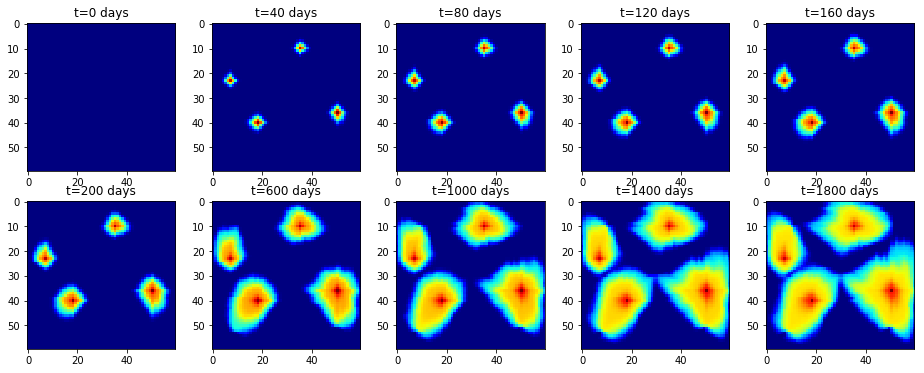

In [7]:
for k in range(4):
    i_case = 100*k+1
    plt.figure(figsize=(16,6))
    print("case number: %d"%(i_case))
    for idx in range(5):
        plt.subplot(2,5, idx+1)
        plt.imshow(sat[i_case, idx*4, :].reshape((60,60)))
        plt.title("t=%d days"%(idx*4*days_per_step))
    for idx in range(5):
        plt.subplot(2,5, idx+6)
        plt.imshow(sat[i_case, idx*40+20, :].reshape((60,60)))
        plt.title("t=%d days"%((idx*40+20)*days_per_step))
plt.show()

case number: 1
case number: 101
case number: 201
case number: 301


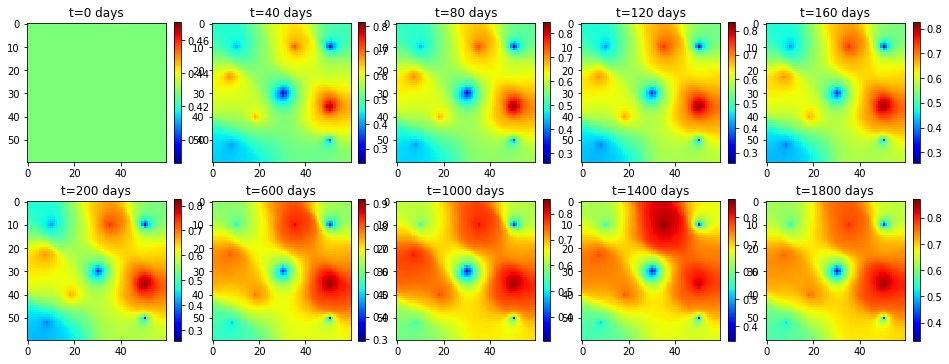

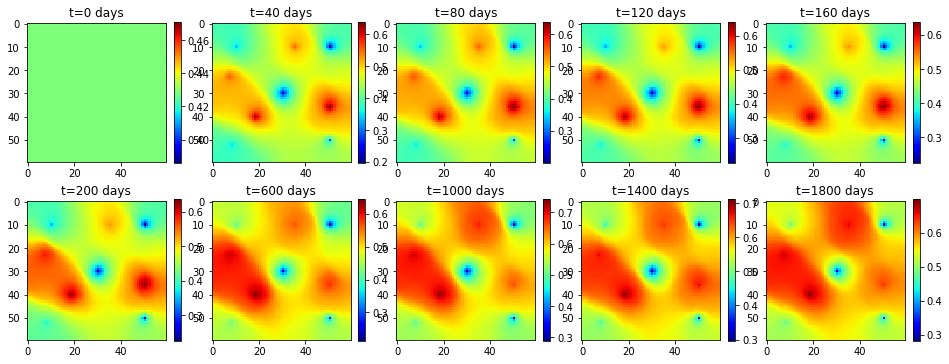

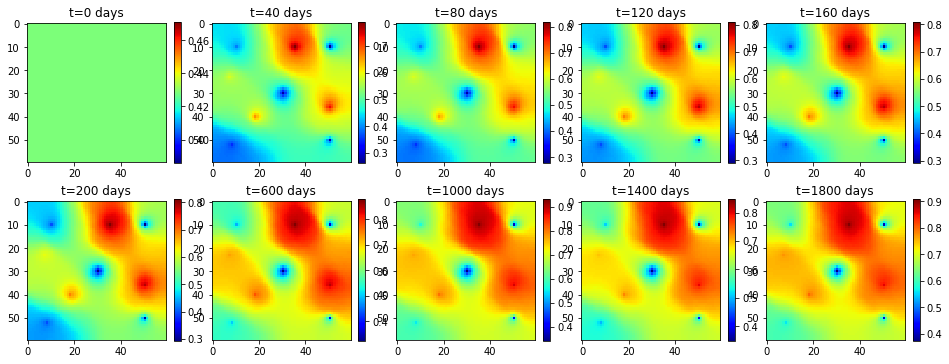

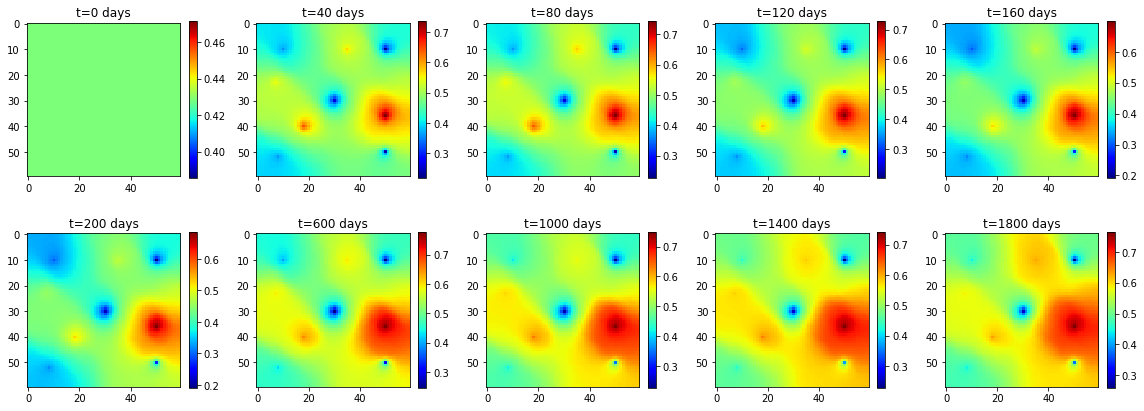

In [8]:
for k in range(4):
    i_case = 100*k+1
    plt.figure(figsize=(16,6))
    print("case number: %d"%(i_case))
    for idx in range(5):
        plt.subplot(2,5, idx+1)
        plt.imshow(pres[i_case, idx*4, :].reshape((60,60)))
        plt.title("t=%d days"%(idx*4*days_per_step))
        plt.colorbar(fraction=0.046)
        
    for idx in range(5):
        plt.subplot(2,5, idx+6)
        plt.imshow(pres[i_case, idx*40+20, :].reshape((60,60)))
        plt.title("t=%d days"%((idx*40+20)*days_per_step))
        plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

(400, 201, 3600)


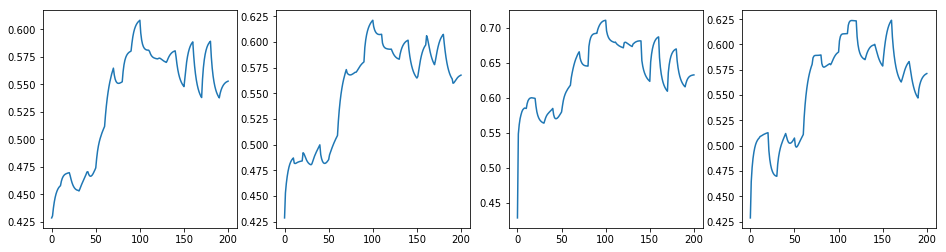

In [9]:
k=[1220, 1240, 2420, 2440]
print(pres.shape)
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(range(201), pres[101,:,k[i]])

(400, 201, 3600)


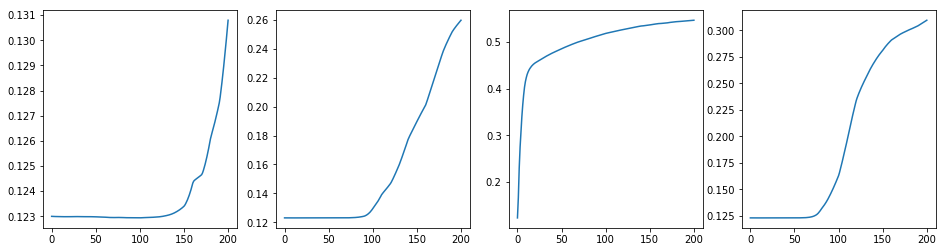

In [10]:
k=[1220, 1240, 2420, 2440]
print(pres.shape)
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(range(201), sat[101,:,k[i]])

#### Constant dt, use the following block (varying dt TBD)

In [11]:
dt = 10 # time step increment, not days
t_interval = 10 # not used, days

indt = np.array(range(0,200,dt))
indt1 = indt + dt
print(indt)
print(indt1)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]


In [12]:
sat_t = sat[:, indt,:]
sat_t1 = sat[:, indt1, :]

pres_t = pres[:, indt,:]
pres_t1 = pres[:, indt1,:]

# we need a delta t
indt_del = indt1 - indt
print(indt_del)

indt_del = indt_del / max(indt_del)
print(indt_del)

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
# print(sat_t1.shape)
# print(pres_t1.shape)

num_t = sat_t.shape[1]
num_case = sat_t.shape[0]

print("num_t:%d"%num_t)
print("num_case:%d"%num_case)

num_t:20
num_case:400


## Read control data

In [14]:
num_prod = 5
num_inj = 4
num_well = num_prod + num_inj

In [15]:
hf_r = h5py.File(data_dir + ctrl_data)
bhp0 = np.array(hf_r.get('bhp'))
rate0 = np.array(hf_r.get('rate'))
hf_r.close()

In [16]:
print(bhp0.shape)
print(rate0.shape)

(400, 100)
(400, 80)


In [17]:
num_ctrl = bhp0.shape[1] // num_prod
assert bhp0.shape[1] // num_prod == rate0.shape[1] // num_inj, "num_ctrl error!"
print(num_ctrl)

20


In [18]:
bhp = np.concatenate((bhp0,rate0),axis=1)
print(bhp.shape)

(400, 180)


## Manipulate control data shape

In [19]:
# with 2 bhps per period
num_step = len(indt)
print(num_step)

20


In [20]:
bhp_b0 = bhp.reshape(num_case, num_well, num_ctrl)
bhp_b1 = np.repeat(bhp_b0[..., np.newaxis], num_step // num_ctrl, axis=3)
assert num_step // num_ctrl * num_ctrl == num_step, "no exaxt division num_step = %d, num_ctrl=%d"%(num_step, num_ctrl)

print(bhp_b1.shape)
bhp_b2 = bhp_b1.reshape(num_case, num_well, num_step)
print(bhp_b2.shape)

(400, 9, 20, 1)
(400, 9, 20)


In [21]:
tmp = np.array(range(num_step)) - 1
tmp1 = np.array(range(num_step))
tmp[0] = 0

print(tmp)
print(tmp1)

[ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [22]:
bhp_tt = bhp_b2[:,:, tmp]
bhp_tt1 = bhp_b2[:,:, tmp1]
print(bhp_tt.shape)
print(bhp_tt1.shape)

bhp_tt0 = np.concatenate((bhp_tt, bhp_tt1), axis=1)
bhp_t = np.swapaxes(bhp_tt0,1,2)
print(bhp_t.shape)
print(bhp.shape)
print(bhp[0,:20]) # these two should be same
print(bhp_t[0,:,9]) # these two should be same
print(bhp_t[0,:,0])

(400, 9, 20)
(400, 9, 20)
(400, 20, 18)
(400, 180)
[0.07301817 0.14255434 0.12567122 0.11029385 0.1277352  0.07266851
 0.0917922  0.08716265 0.09381979 0.11104927 0.09212099 0.06576399
 0.11189337 0.14246813 0.1212841  0.06638636 0.11117457 0.09718268
 0.10476884 0.10050483]
[0.07301817 0.14255434 0.12567122 0.11029385 0.1277352  0.07266851
 0.0917922  0.08716265 0.09381979 0.11104927 0.09212099 0.06576399
 0.11189337 0.14246813 0.1212841  0.06638636 0.11117457 0.09718268
 0.10476884 0.10050483]
[0.07301817 0.07301817 0.14255434 0.12567122 0.11029385 0.1277352
 0.07266851 0.0917922  0.08716265 0.09381979 0.11104927 0.09212099
 0.06576399 0.11189337 0.14246813 0.1212841  0.06638636 0.11117457
 0.09718268 0.10476884]


In [23]:
n_ctrl = bhp_t.shape[2]
print(n_ctrl)

18


In [24]:
# extend dimension of delta_t
print(indt_del.shape)
indt_dd = np.repeat(indt_del[np.newaxis,:], num_case, axis = 0)
indt_d = indt_dd[:,:,np.newaxis]
print(indt_d.shape)

(20,)
(400, 20, 1)


### Pick a fraction of non-changing control periods, and all changing control periods

In [26]:
print(bhp_t[0, 15, [0,9]])
slt_col = np.array((range(0, 100, 5)))
print(slt_col)
#
np.random.seed(1047)
slt_col_2 = np.random.randint(1,5,size=20) + slt_col
print(slt_col_2- slt_col)

slt_cols = np.sort(np.concatenate((slt_col, slt_col_2), axis=0))
print(slt_cols)

[0.1212841  0.06638636]
[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[3 1 3 1 4 4 2 1 2 2 4 3 2 3 3 4 2 3 3 2]
[ 0  3  5  6 10 13 15 16 20 24 25 29 30 32 35 36 40 42 45 47 50 54 55 58
 60 62 65 68 70 73 75 79 80 82 85 88 90 93 95 97]


### If choose not to pick column, run the following one block

In [27]:
slt_cols = np.array((range(num_t)))
print(slt_cols)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [28]:
num_t_slt = slt_cols.shape[0]
print(num_t)
sat_t_slt = sat_t[:,slt_cols,:]
sat_t1_slt = sat_t1[:,slt_cols,:]
pres_t_slt = pres_t[:,slt_cols,:]
pres_t1_slt = pres_t1[:,slt_cols,:]
bhp_t_slt = bhp_t[:,slt_cols,:]
indt_d_slt = indt_d[:,slt_cols,:]

print(sat_t_slt.shape)
print(sat_t1_slt.shape)
print(pres_t_slt.shape)
print(pres_t1_slt.shape)
print(bhp_t_slt.shape)
print(indt_d_slt.shape)

20
(400, 20, 3600)
(400, 20, 3600)
(400, 20, 3600)
(400, 20, 3600)
(400, 20, 18)
(400, 20, 1)


## Train/Test split

In [29]:
num_run_per_case = 75
sat_t_train = np.zeros((num_run_per_case*4, num_t_slt, 3600))
sat_t1_train = np.zeros((num_run_per_case*4, num_t_slt, 3600))
bhp_train = np.zeros((num_run_per_case*4, num_t_slt, n_ctrl))
dt_train = np.zeros((num_run_per_case*4, num_t_slt, 1))

pres_t_train = np.zeros((num_run_per_case*4, num_t_slt, 3600))
pres_t1_train = np.zeros((num_run_per_case*4, num_t_slt, 3600))


num_run_eval = 100 - num_run_per_case # 25 cases
sat_t_eval = np.zeros((num_run_eval*4, num_t_slt, 3600))
sat_t1_eval = np.zeros((num_run_eval*4, num_t_slt, 3600))

bhp_eval = np.zeros((num_run_eval*4, num_t_slt, n_ctrl))
dt_eval = np.zeros((num_run_eval*4, num_t_slt, 1))

pres_t_eval = np.zeros((num_run_eval*4, num_t_slt, 3600))
pres_t1_eval = np.zeros((num_run_eval*4, num_t_slt, 3600))


for k in range(4):
    ind0 = k * num_run_per_case
    sat_t_train[ind0:ind0+num_run_per_case,...] = sat_t_slt[k*100:k*100+num_run_per_case, :, :]
    sat_t1_train[ind0:ind0+num_run_per_case,...] = sat_t1_slt[k*100:k*100+num_run_per_case, :, :]
    pres_t_train[ind0:ind0+num_run_per_case,...] = pres_t_slt[k*100:k*100+num_run_per_case, :, :]
    pres_t1_train[ind0:ind0+num_run_per_case,...] = pres_t1_slt[k*100:k*100+num_run_per_case, :, :]
    bhp_train[ind0:ind0+num_run_per_case,...] = bhp_t_slt[k*100: k*100+num_run_per_case, :, :]
    dt_train[ind0:ind0+num_run_per_case,...] = indt_d_slt[k*100: k*100+num_run_per_case, :, :]
    # Eval set
    ind1 = k*num_run_eval
    sat_t_eval[ind1:ind1+num_run_eval,...] = sat_t_slt[k*100+num_run_per_case:k*100+100, :, :]
    sat_t1_eval[ind1:ind1+num_run_eval,...] = sat_t1_slt[k*100+num_run_per_case:k*100+100, :, :]
    pres_t_eval[ind1:ind1+num_run_eval,...] = pres_t_slt[k*100+num_run_per_case:k*100+100, :, :]
    pres_t1_eval[ind1:ind1+num_run_eval,...] = pres_t1_slt[k*100+num_run_per_case:k*100+100, :, :]
    bhp_eval[ind1:ind1+num_run_eval,...] = bhp_t_slt[k*100+num_run_per_case: k*100+100, :, :]
    dt_eval[ind1:ind1+num_run_eval,...] = indt_d_slt[k*100+num_run_per_case: k*100+100, :, :]

In [30]:
n_train_run = sat_t_train.shape[0]
n_eval_run = sat_t_eval.shape[0]

In [31]:
sat_t_train = sat_t_train.reshape((num_run_per_case*4*num_t_slt, 60, 60, 1))
sat_t1_train = sat_t1_train.reshape((num_run_per_case*4*num_t_slt, 60, 60, 1))
pres_t_train = pres_t_train.reshape((num_run_per_case*4*num_t_slt, 60, 60, 1))
pres_t1_train = pres_t1_train.reshape((num_run_per_case*4*num_t_slt, 60, 60, 1))
bhp_train = bhp_train.reshape((num_run_per_case*4*num_t_slt, n_ctrl))
dt_train = dt_train.reshape((num_run_per_case*4*num_t_slt, 1))
# Eval
sat_t_eval = sat_t_eval.reshape((num_run_eval*4*num_t_slt, 60, 60, 1))
sat_t1_eval = sat_t1_eval.reshape((num_run_eval*4*num_t_slt, 60, 60, 1))
pres_t_eval = pres_t_eval.reshape((num_run_eval*4*num_t_slt, 60, 60, 1))
pres_t1_eval = pres_t1_eval.reshape((num_run_eval*4*num_t_slt, 60, 60, 1))
bhp_eval = bhp_eval.reshape((num_run_eval*4*num_t_slt, n_ctrl))
dt_eval = dt_eval.reshape((num_run_eval*4*num_t_slt, 1))

In [32]:
n_train_step = sat_t_train.shape[0]
n_eval_step = sat_t_eval.shape[0]


In [33]:
state_t_train = np.concatenate((sat_t_train, pres_t_train),axis=3)
state_t1_train = np.concatenate((sat_t1_train, pres_t1_train),axis=3)

state_t_eval = np.concatenate((sat_t_eval, pres_t_eval),axis=3)
state_t1_eval = np.concatenate((sat_t1_eval, pres_t1_eval),axis=3)

In [34]:
num_train = num_run_per_case*4*num_t_slt
shuffle_ind_train = np.random.permutation(num_train)
state_t_train = state_t_train[shuffle_ind_train, ...]
state_t1_train = state_t1_train[shuffle_ind_train, ...]
bhp_train = bhp_train[shuffle_ind_train, ...]
dt_train = dt_train[shuffle_ind_train, ...]

In [35]:
num_eval = num_run_eval*4*num_t_slt
shuffle_ind_eval = np.random.permutation(num_eval)
state_t_eval = state_t_eval[shuffle_ind_eval, ...]
state_t1_eval = state_t1_eval[shuffle_ind_eval, ...]
bhp_eval = bhp_eval[shuffle_ind_eval, ...]
dt_eval = dt_eval[shuffle_ind_eval, ...]

In [37]:
# select subset of training
n_train_step = 6000
state_t_train = state_t_train[:n_train_step, ...]
state_t1_train = state_t1_train[:n_train_step, ...]
bhp_train = bhp_train[:n_train_step, ...]
dt_train = dt_train[:n_train_step, ...]

In [38]:
print(dt_train.shape)
dt = 100 # days

(6000, 1)


In [39]:
hf_w = h5py.File(data_dir + case_name + '_e2c_train' + case_suffix + train_suffix+ '_n%d_dt%dday_nt%d_nrun%d.mat' %(n_train_step, dt, num_t_slt, n_train_run), 'w')
hf_w.create_dataset('state_t', data=state_t_train)
hf_w.create_dataset('state_t1', data=state_t1_train)
hf_w.create_dataset('bhp', data = bhp_train)
hf_w.create_dataset('dt', data = dt_train)
hf_w.close()

In [40]:
print(bhp_eval.shape)
print(dt_eval.shape)

(2000, 18)
(2000, 1)


In [41]:
hf_w = h5py.File(data_dir + case_name + '_e2c_eval' + case_suffix + train_suffix+'_n%d_dt%dday_nt%d_nrun%d.mat'%(n_eval_step, dt, num_t_slt, n_eval_run), 'w')
hf_w.create_dataset('state_t', data=state_t_eval)
hf_w.create_dataset('state_t1', data=state_t1_eval)
hf_w.create_dataset('bhp', data = bhp_eval)
hf_w.create_dataset('dt', data = dt_eval)
hf_w.close()